# Part 2: Using DeerLab for fitting DEER

### Learning Objectives of Part 2

- To obtain a basic understanding on how load, pre-process and analyze DEER data
- To be able to define different types of DEER models 
- To be able to analyze DEER data with contributions from multiple dipolar pathways

----------------

## 0. Importing DeerLab and other packages

Remember: Python packages must be imported before using their contents. 

In [121]:
# Import basic packages
import numpy as np  # NumPy: vectors, matrices, linear algebra
import matplotlib.pyplot as plt  # Matplotlib: plotting

As with other Python packages, DeerLab must be imported at the start of script before being able to access any of its functions. We recommend to use ``dl`` as the standard import abbreviation for DeerLab. 

In [122]:
import deerlab as dl

---------------------

## 1. Loading data into DeerLab

DeerLab provides the function [``deerload``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.deerload.html#deerlab.deerload) that can load dipolar EPR data from most spectrometer file formats. The function [``deerload``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.deerload.html#deerlab.deerload) is a Python version of the very well known ``eprload`` from the EasySpin package for MATLAB. It works for 1D and 2D datasets, both real- or complex-valued. For data files in ASCII format, Numpy provides robust loading functions such as ``loadtxt`` which can be used in the same way as [``deerload``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.deerload.html#deerlab.deerload).  

Further information:
- [``deerload`` documentation](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.deerload.html#deerlab.deerload)
- [``loadtxt`` documentation](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html)

To load the data file ``example_4pdeer_4.DTA`` we can specify the relative path to the file from our ``notebooks`` folder, i.e. ``path=../data/``.  

*Tipp:* In Windows computers, by right-clicking a file while pressing ``Shift`` one can select the option ``Copy as path`` to automatically copy the full path of the file. This can then be directly pasted into your script to effortlessly load the data.


The [``deerload``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.deerload.html#deerlab.deerload) function returns two outputs: the first is the dipolar time-axis of your experiment, and the second is the raw experimental data as saved by your spectrometer. Both are returned as Numpy ``ndarrays``. Here, we store them in variables named ``t`` and ``Vexp``.

In [123]:
# Load the data
t,Vexp = dl.deerload('../../data/example_4pdeer_4.DTA')

# Check the type of variable of Vexp
type(Vexp)

numpy.ndarray

The function [``deerload``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.deerload.html#deerlab.deerload) attempts to return the experiment time-axis ``t`` in units of microseconds, but might not be able to do so for all file formats. It is important to check that the time-axis has the correct units. 

**Important:** All dipolar EPR-related models in DeerLab define time units in microseconds and distance units in nanometers!

This can be easily checked by, e.g. printing the variable ``t`` steps

In [124]:
print('dt =',t[1]-t[0]) 

dt = 0.008


...or by plotting the data:

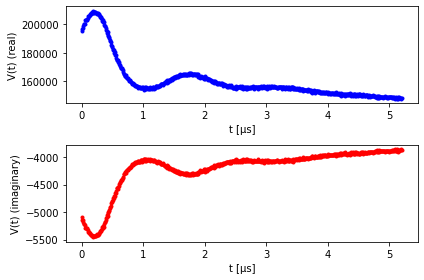

In [125]:
# First subplot, real part of the data 
plt.subplot(2,1,1) 
plt.plot(t,Vexp.real,'b.')
plt.xlabel('t [μs]')
plt.ylabel('V(t) (real)')

# Second subplot, imaginary part of the data 
plt.subplot(2,1,2)
plt.plot(t,Vexp.imag,'r.')
plt.xlabel('t [μs]')
plt.ylabel('V(t) (imaginary)')

# Do not allow plots to overlap
plt.tight_layout() 

# Show the plot
plt.show()

-------------------------------

## 2. Pre-processing

While DeerLab can handle pure raw data (even in complex form) it can facilitate our analysis to perform a couple of simple pre-processing steps. 

### Phase correction

Experimental dipolar signals are most often acquired in quadrature, with the in-phase and the out-of-phase component stored as the real and the imaginary part of a complex-valued signal. 

If the out-of-phase components are of no relevance, it is recommendable to perform a phase correction which minimizes the imaginary component and maximizes the real component. If the signal is not complex-valued or the out-of-phase component is important, skip this step. 

The phase correction function [``correctphase``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.correctphase.html#deerlab.correctphase) takes the complex-valued signal and returns the real-valued phase-corrected dipolar signal.


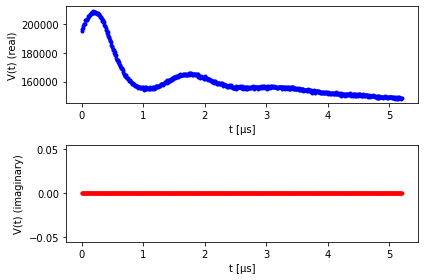

In [126]:
# Phase correction
Vexp = dl.correctphase(Vexp)

# First subplot, real part of the data 
plt.subplot(2,1,1) 
plt.plot(t,Vexp.real,'b.')
plt.xlabel('t [μs]')
plt.ylabel('V(t) (real)')

# Second subplot, imaginary part of the data 
plt.subplot(2,1,2)
plt.plot(t,Vexp.imag,'r.')
plt.xlabel('t [μs]')
plt.ylabel('V(t) (imaginary)')

# Do not allow plots to overlap
plt.tight_layout() 

# Show the plot
plt.show()


### Accounting for the start time 

DeerLab assumes that the dipolar time evolution has its zero-time inmediately after the pulse. For example: 

<img style="width:500px; alignment:center" src="https://raw.githubusercontent.com/JeschkeLab/DeerLabWorkshop2022/main/images/4pdeer_sequence_starttime.svg">

Since experiments usually have a certain time $t_0$ during which the echo modulation is not acquired, we must account for that. Sadly most spectrometers do not automatically do this and we must take care that its definition is correct. 

*Note:* This is information that must be noted by the user as DeerLab cannot robustly extract that from the data files. 

For our current experimental 4-pulse DEER signal, the data was acquired with the following experimental setup: 

| Delay | Length | Description | 
| :---: | :---: | --- |
| $\tau_1$ |  0.5μs |       First inter-pulse delay | 
| $\tau_2$ |  5.0μs  |      Second inter-pulse delay | 
| $t_0$ |  0.3μs |  Start time | 


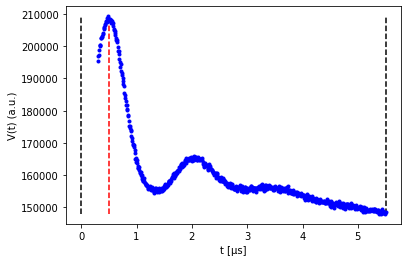

In [127]:
# Experimental parameters
tau1 = 0.5 # μs
tau2 = 5.0 # μs 
t0   = 0.3 # μs 

# Account for the start time
t = t - t[0]   # Set the first time interval to zero 
t = t + t0     # Account for the start time

# Plot the phase corrected signal on the start-time corrected time axis
plt.plot(t,Vexp,'b.')
plt.xlabel('t [μs]')
plt.ylabel('V(t) (a.u.)')

# Add some vertical lines for illustration
plt.vlines(0,min(Vexp),max(Vexp),'k',linestyle='dashed')
plt.vlines(tau1+tau2,min(Vexp),max(Vexp),'k',linestyle='dashed')
plt.vlines(tau1,min(Vexp),max(Vexp),'r',linestyle='dashed')

plt.show()

------------------
## Exercise 2.1 

Go to ``Exercise 2.1`` on the exercise file: ``02b-deerlab-fitting-exercises.ipynb``

---------------

## 3. Constructing a model of the data

DeerLab provides a very flexible framework to model dipolar signals originating from any dipolar EPR spectroscopy experiments. Choosing a model that properly describes your sample and experiment is of paramount importance. To construct a model of a dipolar signal, DeerLab provides the [``dipolarmodel``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel) function, which will contruct different dipolar models based on your needs.

The minimum information that you need to provide to [``dipolarmodel``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel) is the vector of dipolar evolution times $t$ and the vector of interspin distances $r$.

    Vmodel = dl.dipolarmodel(t,r)

By doing so, [``dipolarmodel``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel) will construct a single-pathway dipolar model with a non-parametric distance distribution and assume a background arising from a homogeneous 3D-distribution of spins in space.

The function will return an instance of a DeerLab [``Model``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.Model.html#deerlab.Model). All DeerLab models can be inspected via the ``print()`` command to dispay a full summary of the model details. 

In [128]:
# Define the distance range
r = np.arange(2.2,5.2,0.02) # range from 2.2-5.2nm with 0.02nm resolution

# Construct the dipolar model
Vmodel = dl.dipolarmodel(t,r) 

# Display information about the dipolar model
print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, conc, P)
Constants: []
Parameter Table: 
========= ======= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Start   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======= ======== ======== ====== ====================================== 
 mod           0    0.01       1   nonlin     No            Modulation depth                      
 reftime    -inf       0     inf   nonlin     No      μs    Refocusing time                       
 conc       0.01      50   5e+03   nonlin     No      μM    Spin concentration                    
 P             0       0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======= ======== ======== ====== ====================================== 


The dipolar pathways of a newly constructed dipolar model are initialized at arbitrary refocusing times. This can result in unstable fits under certain conditions. It is recommended to constrain this parameter.

The refocusing times can be strongly constrained by knowing the experimental pulse sequence delays used to acquire the data. If the experiment used to acquire the data is known, as well as its pulse delays, then it is **strongly recommended** do so.

DeerLab provides a [selection of experiment models](https://jeschkelab.github.io/DeerLab/modelsref.html) for some of the most widely employed experimental methods (all experiment model names start with the prefix ``ex_`` for clarity). These are functions that take the pulse sequence delays, and return an object with specific information about the experiment. This can be passed to the [``dipolarmodel``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel) function via the ``experiment`` keyword argument, to incorporate the experiment information into the model and constrain some of its parameters based on a theoretical physical basis. 

These experiment models can also be used to easily and robustly introduce further dipolar pathways into the model. We will explore this later. 

In our case, for the 4-pulse DEER experiment, the corresponding model is [``ex_4pdeer``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.ex_4pdeer.html#deerlab.ex_4pdeer). By checking the [corresponding documentation](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.ex_4pdeer.html#deerlab.ex_4pdeer) we see  

<img src="https://raw.githubusercontent.com/JeschkeLab/DeerLabWorkshop2022/main/images/4pdeer_pathways_docs.png" alt="drawing" style="width:700px;"/>

The experiment model [``ex_4pdeer``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.ex_4pdeer.html#deerlab.ex_4pdeer) takes first the two pulse delays $\tau_1$ and $\tau_2$ as arguments. The model takes a last (optional) argument ``pathways`` which allows us to specify which dipolar pathways of the [``ex_4pdeer``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.ex_4pdeer.html#deerlab.ex_4pdeer) model to include in our model. If not specified, the program will account for all possible pathways defined in that model.

In our case we are interested solely in pathway #1 (the "intended" pathway) and can neglect any other pathways. Thus, we need to specify to the [``ex_4pdeer``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.ex_4pdeer.html#deerlab.ex_4pdeer) model that we are only interested in pathway #1.  

In [129]:
# Construct model of our 4-pulse DEER experiment
my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1])

# Construct the dipolar signal model including experimental information
Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer) 

# Display information about the model
print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, conc, P)
Constants: []
Parameter Table: 
========= ======= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Start   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======= ======== ======== ====== ====================================== 
 mod           0    0.01       1   nonlin     No            Modulation depth                      
 reftime   0.452     0.5   0.548   nonlin     No      μs    Refocusing time                       
 conc       0.01      50   5e+03   nonlin     No      μM    Spin concentration                    
 P             0       0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======= ======== ======== ====== ====================================== 


------------------
## Exercise 2.2 

Go to ``Exercise 2.2`` on the exercise file: ``02b-deerlab-fitting-exercises.ipynb``

--------------------------

## 4. Fitting the model to the data


Once a model has been constructed, it can be fitted to the data easily via the [``fit``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.fit.html#deerlab.fit) function. DeerLab will automatically take care of deciding which solvers and algorithms are best suited for your model. The fitting can be started just by passing the model and the data:

        results = dl.fit(Vmodel,Vexp)

By default DeerLab will always estimate the uncertainty in the results based on the curvature of the objective function. This method is fast and provides a good first estimate of the uncertainty. However, the uncertainty is often overestimated by this method. 
For publication-grade analysis it is recommended to use bootstrapping, which provides the most accurate confidence intervals available. Bootstrapping can be included in your analysis by specifying the ``bootstrap=Nsamples`` keyword argument with a high-enough number of sampled

        results = dl.fit(Vmodel,Vexp,bootstrap=1000)

Note that bootstrap is a highly costly (and thus slow) approach. It is not recommended to use for first-time analyses. 

When using non-parametric distance distributions, DeerLab will automatically use Tikhonov regularization to fit the model to the data. Regularization can be manually turned on/off via the ``reg`` optional argument. 

By default, the regularization parameter will be selected according to the Akaike information criterion (AIC). The selection criterion can be changed using the ``regparam`` argument, e.g.

        # Bayesian information criterion
        results = dl.fit(Vmodel,Vexp,regparam='aic') 
        # Akaike information criterion
        results = dl.fit(Vmodel,Vexp,regparam='bic') 
        # L-curve
        results = dl.fit(Vmodel,Vexp,regparam='lc') 

A fixed regularization parameter can be also specified by passing the specific value to the ``regparm`` option. 

*Note*: Due to the low-resources of JupyterLab for this workshop we will adjust the algorithm stopping criterion via the ``ftol`` optional argument and fix the regularization parameter to a AIC-based pre-computed value using the ``regparam`` optional argument. This is **only required for the online workshop**.  The ``verbose`` optional argument enables the display of details on the ongoing fitting procedure.


In [130]:
# Fit the model to the data
results = dl.fit(Vmodel,Vexp,verbose=2,  ftol=1e-3, regparam=0.0908)

# For your data, leave the regparam and ftol options to their defaults (here needed due to low resources)

[11-8-2022 5:43:49] Preparing the SNLLS analysis...
[11-8-2022 5:43:49] Preparations completed.
[11-8-2022 5:43:49] Non-linear least-squares routine in progress...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.3169e+10                                    4.86e+11    
       1              2         2.1404e+09      6.10e+10       1.67e+02       8.16e+09    
       2              3         3.4809e+08      1.79e+09       7.05e+01       1.99e+10    
       3              4         7.4040e+07      2.74e+08       2.72e+01       8.97e+09    
       4              5         7.0403e+07      3.64e+06       5.82e-01       5.24e+08    
       5              6         7.0369e+07      3.41e+04       1.34e-01       1.06e+07    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 6.3169e+10, final cost 7.0369e+07, first-order optimality 1.06e+07.
[11-8-2022 5:43:52] Least-squares routine finished.

For just a quick display of the results, you can use the ``plot()`` method of the ``results`` object that will display a figure with you experimental data, the corresponding fit including confidence bands. This allows a quick visual assessment of whether the model has been correctly fitted to the data. 

The time axis and a corresponding label can be speficied as well using the ``axis`` and ``xlabel`` optional arguments. 

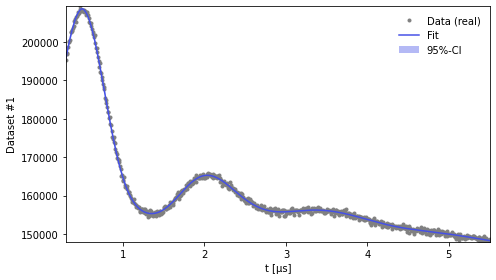

In [131]:
# Plot the experimental data and fit
results.plot(axis=t,xlabel='t [μs]')

# Show the plot
plt.show() 

------------------
## Exercise 2.3 

Go to ``Exercise 2.3`` on the exercise file: ``02b-deerlab-fitting-exercises.ipynb``

--------------------

## 5. Fit parameters & Uncertainties

For a quick summary of the fit results, including goodness-of-fit statistics and the fitted model parameter values (including 95% confidence intervals), can be accessed by just printing the results object

In [132]:
print(results)

Goodness-of-fit: 
========= ============= ============ ========= ========== 
 Dataset   Noise level   Reduced 𝛘2    RMSD       AIC     
========= ============= ============ ========= ========== 
   #1        472.720       0.992      462.502   1.22e+04  
========= ============= ============ ========= ========== 
Model hyperparameters: 
 Regularization parameter  
          0.091            
Model parameters: 
=========== ==================== ========================= ====== ====================================== 
 Parameter   Value                95%-Confidence interval   Unit   Description                           
=========== ==================== ========================= ====== ====================================== 
 mod         0.200                (0.199,0.202)                    Modulation depth                      
 reftime     0.499                (0.496,0.501)              μs    Refocusing time                       
 conc        118.982              (117.453,120.511)       

These quantities and their uncertinaties are easily accessed from the ``results`` object by their parameter names as

    results.<parameter>
    results.<parameter>Uncert

For example to extract the fitted distance distribution (given by the parameter ``P``) once can simply get the ``results.P`` values. Similarly to extract its uncertainty, one can simply get the ``results.PUncert`` value. This returns a so-called [uncertainty quantification](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.UQResult.html#deerlab.UQResult) object.  

This uncertainty quantification object contains all kinds of quantities that describe the uncertainty of the quantity. Typically we interested in reporting the uncertainty based on confidence intervals. These can be easily calculated using the ``ci()`` method of the uncertainty quantification. 

For example to extract the fit and 95%-confidence intervals (bands) of the non-parametric distance distribution:

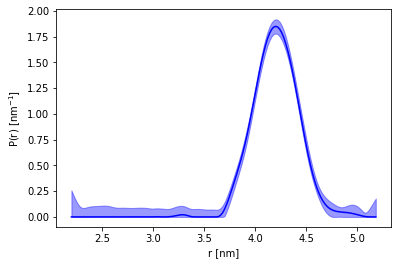

In [133]:
# Get the fitted distance distribution
Pfit = results.P
# Get the uncertainty quantification of the distance distribution
Puq = results.PUncert
# Get its 95% confidence intervals
Pci95 = Puq.ci(95)

# Get the lower/upper boundaries of the confidence intervals
Pci95_lower = Pci95[:,0]
Pci95_upper = Pci95[:,1]

# Plot the fitted distance distribution
plt.plot(r,Pfit,'b')
# Plot the confidence bands as a filled area
plt.fill_between(r,Pci95_lower,Pci95_upper,color='b',alpha=0.4)
plt.xlabel('r [nm]')
plt.ylabel('P(r) [nm$^{-1}$]')
plt.show()

Other model parameters can be easily obtained from the ``results`` object as well by using their parameter names. 

In [134]:
# Modulation depth
mod_fit = results.mod
mod_ci95 = results.modUncert.ci(95)

# Spin concentration
conc_fit = results.conc
conc_ci95 = results.concUncert.ci(95)


print('Modulation depth:',mod_fit,mod_ci95)
print('Spin concentration:',conc_fit,conc_ci95)

Modulation depth: 0.20042874838564964 [0.19908857 0.20176893]
Spin concentration: 118.98201735278532 [117.4531689 120.5108658]


Usually, many structural biology software require information on descriptors of the distance distribution (such as the mean distance and standard deviation) rather than the full distribution. 

DeerLab provides an utility function ``diststats`` to obtain a summary of descriptors of the estimated distance distribution (with uncertainties).  

In [135]:
stats = dl.diststats(r,Pfit,Puq,verbose=True)

-------------------------------------------------
Distribution Statistics
-------------------------------------------------
Range                    2.20-5.18 nm
Integral                 1.00
-------------------------------------------------
Location
-------------------------------------------------
Range                    2.20-5.18 nm
Mean                     4.20 (4.19,4.22) nm
Median                   4.20 (4.20,4.21) nm
Interquartile mean       4.20 (4.20,4.20) nm
Mode                     4.20 nm
-------------------------------------------------
Spread
-------------------------------------------------
Standard deviation       0.22 (0.15,0.29) nm
Mean absolute deviation  0.17 (0.16,0.18) nm
Interquartile range      0.29 (0.28,0.30) nm
Variance                 0.05 (0.02,0.08) nm²
-------------------------------------------------
Shape
-------------------------------------------------
Modality                 1
Skewness                 0.07 (-6.16,6.30) 
Kurtosis                 -0.

------------------
## Exercise 2.4 

Go to ``Exercise 2.4`` on the exercise file: ``02b-deerlab-fitting-exercises.ipynb``

-----------------------

## 6. Customizing the dipolar model

We have seen that in its default behavior, [``dipolarmodel``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel) will construct a single-pathway model of the dipolar signal with a non-parametric distance distribution. The function provides the means to construct alternative models of dipolar signals making use of built-in models to represent distance distributions and background decays. 

Any choice of distribution and background decay models can be specified in [``dipolarmodel``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel) via the ``Pmodel`` and ``Bmodel`` keyword arguments, respectively.

- Distance distribution model

    A non-parametric distribution is specified by setting the choice of ``Pmodel`` in [``dipolarmodel``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel) to ``None``. If there are reasons to believe that the distance distribution has a specific shape, e.g. Gaussian ([``dd_gauss``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dd_gauss.html#deerlab.dd_gauss)), Rice ([``dd_rice``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dd_rice.html#deerlab.dd_rice)), random-coil ([``dd_randcoil``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dd_randcoil.html#deerlab.dd_randcoil)), etc., or if there is very little information in the data, use a parametric distance distribution. Distance distribution models can be recognized by the prefix ``dd_`` in their names. 
    
    See the [list of available models](https://jeschkelab.github.io/DeerLab/modelsref.html).  

- Background decay model

    Typically, a background model of a homogenous 3D distribution of spins ([``bg_hom3d``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.bg_hom3d.html#deerlab.bg_hom3d)) is appropriate and makes the least number of assumptions about the sample. In some cases, depending on the properties of your sample, other background models might be needed, such as backgrounds arising from distributions of spins in fractal dimensions ([``bg_homfractal``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.bg_homfractal.html#deerlab.bg_homfractal)) or when accounting for volume-exclusion effects ([``bg_hom3dex``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.bg_hom3dex.html#deerlab.bg_hom3dex)). In such cases, use the associated parametric background models from the list of available models. If there is no inter-molecular background in your sample, or it is negligible, set the background model to ``None``. Both physical and phenomenological background decay models can be recognized by the prefix ``bg_`` in their names. 
    
    See the [list of available models](https://jeschkelab.github.io/DeerLab/modelsref.html).  

The [``dipolarmodel``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel) function provides optional arguments to further specify other properties of the dipolar signal models such as: 

- Orientation selection (through the ``orisel`` keyword argument).
- Limited excitation bandwidth effects (through the ``excbandwidth`` keyword argument).
- Harmonic (or overtone) contributions (throught the ``harmonics`` keyword argument).

and other details that are listed in the [reference documentation](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel) of [``dipolarmodel``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel).

For this example, let's build a model where the distance distribution is modeled as a single Gaussian ([``dd_gauss``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dd_gauss.html#deerlab.dd_gauss)) and the background decay is treated phenomenologically as a stretched exponential function ([``bg_strexp``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.bg_strexp.html#deerlab.bg_strexp)).

In [136]:
# Construct the dipolar model with a Gaussian distance distribution and stretched exponential background 
Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer, Pmodel=dl.dd_gauss, Bmodel=dl.bg_strexp) 

# Display information about the dipolar model
print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, decay, stretch, mean, std, scale)
Constants: []
Parameter Table: 
========= ======= ======= ======= ======== ======== ====== ==================== 
 Name      Lower   Start   Upper    Type    Frozen   Unit   Description         
========= ======= ======= ======= ======== ======== ====== ==================== 
 mod           0    0.01       1   nonlin     No            Modulation depth    
 reftime   0.452     0.5   0.548   nonlin     No      μs    Refocusing time     
 decay         0    0.25     200   nonlin     No     μs⁻¹   Decay rate          
 stretch       0       1       6   nonlin     No            Stretch factor      
 mean          1     3.5      20   nonlin     No      nm    Mean                
 std        0.05     0.2     2.5   nonlin     No      nm    Standard deviation  
 scale         0       1     inf   linear     No     None   None                
========= ======= ======= ======= ======== ======== ====== =====

As before, we just need to use the [``fit``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.fit.html#deerlab.fit) function to fit our new model to the data. 

[11-8-2022 5:43:56] Preparing the SNLLS analysis...
[11-8-2022 5:43:56] Preparations completed.
[11-8-2022 5:43:56] Non-linear least-squares routine in progress...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.7474e+11                                    2.22e+12    
       1              2         1.1944e+11      5.55e+11       6.26e-01       4.58e+11    
       2              3         2.6893e+10      9.25e+10       1.20e+00       8.68e+10    
       3              4         7.3081e+09      1.96e+10       9.71e-01       6.31e+10    
       4              5         2.1886e+09      5.12e+09       3.02e-01       1.43e+10    
       5              6         1.7217e+09      4.67e+08       5.15e-01       3.16e+12    
       6              8         6.4538e+08      1.08e+09       1.02e-01       8.68e+10    
       7              9         5.5746e+08      8.79e+07       1.56e-01       1.45e+13    
       8         

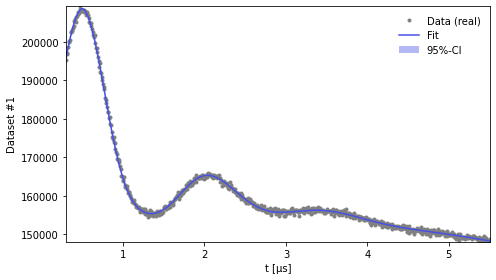

In [137]:
# Fit the model to the data
results = dl.fit(Vmodel,Vexp,verbose=2, ftol=1e-3)

# Plot the experimental data and fit
results.plot(axis=t,xlabel='t [μs]')
plt.show() 

Now, let's check again the summery of the fit's results via the ``print()`` function.

In [138]:
print(results)

Goodness-of-fit: 
========= ============= ============ ========= ========== 
 Dataset   Noise level   Reduced 𝛘2    RMSD       AIC     
========= ============= ============ ========= ========== 
   #1        472.720       0.983      466.637   1.22e+04  
========= ============= ============ ========= ========== 
Model parameters: 
=========== ========== ========================= ====== ==================== 
 Parameter   Value      95%-Confidence interval   Unit   Description         
=========== ========== ========================= ====== ==================== 
 mod         0.200      (0.199,0.201)                    Modulation depth    
 reftime     0.499      (0.497,0.501)              μs    Refocusing time     
 decay       0.024      (0.023,0.025)             μs⁻¹   Decay rate          
 stretch     0.996      (0.970,1.022)                    Stretch factor      
 mean        4.200      (4.196,4.205)              nm    Mean                
 std         0.213      (0.209,0.217)       

Note that with this new model, there is no parameter that directly represents the distance distribution, since it is parametrized by the ``mean`` and ``std`` parameters. 

To get the fitted distance distribution, we must evaluate the distance distribution model (in this case [``dd_gauss``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dd_gauss.html#deerlab.dd_gauss)) with the fitted parameter values. Similarly, to obtain estimates of the distance distribution's uncertainty we must propagate the uncertainty from the parameters to the distance distirbution model. 

To avoid having to do this by hand, DeerLab's ``results`` object provides two utility methods ``results.evaluate()`` and ``results.propagate()`` that achieve this in a user-friendly fashion. 

Both the ``results.evaluate()`` and ``results.propagate()`` methods take the model which has to be evaluated as a first argument and any constants needed by that model as additional arguments. For this to work, the ``results`` object must contain all the parameters required by model to be evaluated. In our case, we want to evaluate the model [``dd_gauss``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dd_gauss.html#deerlab.dd_gauss)) which requires the constant ``r``. 

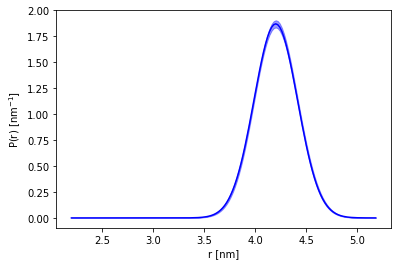

In [139]:
# Evaluate the distance distribution at the fitted parameter values
Pfit = results.evaluate(dl.dd_gauss,r)

# Propagate the uncertainty in the parameteres to the distance distribution model
Puq = results.propagate(dl.dd_gauss,r)

# Get its 95% confidence intervals
Pci95 = Puq.ci(95)

# Get the lower/upper boundaries of the confidence intervals
Pci95_lower = Pci95[:,0]
Pci95_upper = Pci95[:,1]

# Plot the fitted distance distribution
plt.plot(r,Pfit,'b')
# Plot the confidence bands as a filled area
plt.fill_between(r,Pci95_lower,Pci95_upper,color='b',alpha=0.4)
plt.xlabel('r [nm]')
plt.ylabel('P(r) [nm$^{-1}$]')
plt.show()



---------------

## 7. Fitting DEER data with multiple pathway contributions 

Dipolar signals can be described as a combination of contributions arising from different dipolar pathways. The intramolecular contribution consists of a sum and the intermolecular contribution consists of a product over individual dipolar pathway contributions. Each pathway has a characteristic refocusing time (point in time ``t`` where the pathway's contribution is largest) and amplitude. 

For example, for the 4-pulse DEER experiment, the possible dipolar pathways are:

<img src="https://github.com/JeschkeLab/DeerLabWorkshop2022/raw/main/images/pathways_scheme.png" alt="drawing" style="width:300px; margin:auto; display:block; "/>


| Pathway | Refocusing time | Description | 
| :---: | ------ | -------------- |
| 1 | $t = \tau_1$ | Main contribution |
| 2 | $t = \tau_1+\tau_2$ | "2+1" contribution | 
| 3 | $t = 0$  | "Inverse 2+1" contribution | 
| 4 | $t = \tau_2$ | No description  | 


In this demonstration we will analyze the experimental 4-pulse DEER data ``example_4pdeer_5.DTA`` with additional pathway contributions due to, e.g., pulse excitation overlap. The data was acquired with the following experimental parameters: 

| Delay | Length | Description | 
| :---: | :---: | --- |
| $\tau_1$ |  0.4μs |       First inter-pulse delay | 
| $\tau_2$ |  3.0μs  |      Second inter-pulse delay | 
| $t_0$ |  0.04μs |  Start time | 

As we know now, the first step requires the loading and pre-processing of the data. Note that most of the script can be recycled from the previous examples.

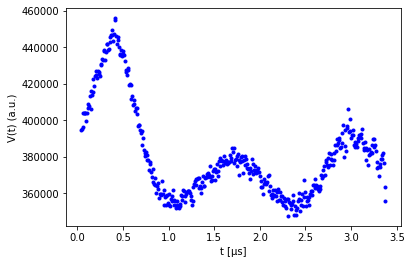

In [140]:
# Experimental parameters
tau1 = 0.4      # First inter-pulse delay, μs
tau2 = 3.0      # Second inter-pulse delay, μs
deadtime = 0.04  # Acquisition start time, μs

# Load the experimental data
t,Vexp = dl.deerload('../../data/example_4pdeer_5.DTA')

# Pre-processing
Vexp = dl.correctphase(Vexp) # Phase correction
t = t + deadtime             # Account for deadtime

# Plot the pre-processed data
plt.plot(t,Vexp,'b.')
plt.xlabel('t [μs]')
plt.ylabel('V(t) (a.u.)')
plt.show()

The only difference in the analysis of data with multiple dipolar pathway contributions is just the definition of a new dipolar model that accounts for those pathways. Fortunately, this task is easily accomplished in DeerLab by combining the [``dipolarmodel``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.dipolarmodel.html#deerlab.dipolarmodel) and [``ex_4pdeer``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.ex_4pdeer.html#deerlab.ex_4pdeer) functions. 

As we have seen before, the [``ex_4pdeer``](https://jeschkelab.github.io/DeerLab/_autosummary/deerlab.ex_4pdeer.html#deerlab.ex_4pdeer) allows us to specify which pathways of the 4-pulse DEER to account for in the model. In this case, we will account for all dipolar pathways in the model.

Otherwise we will use the default dipolar model setup, i.e. a non-parametric distance distribution and a homogeneous 3D-distribution background decay.  

In [141]:
# Distance vector
r = np.arange(2.5,5,0.05) # nm

# Construct the model
pathways4pdeer = dl.ex_4pdeer(tau1,tau2, pathways=[1,2,3,4])
Vmodel = dl.dipolarmodel(t,r,experiment=pathways4pdeer)

# Fit the model to the data
results = dl.fit(Vmodel,Vexp, verbose=2, regparam=0.169, ftol=1e-2)

# Print results summary
print(results)

[11-8-2022 5:44:1] Preparing the SNLLS analysis...
[11-8-2022 5:44:1] Preparations completed.
[11-8-2022 5:44:1] Non-linear least-squares routine in progress...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0940e+11                                    1.20e+12    
       1              2         2.0123e+10      8.93e+10       1.89e+00       3.55e+11    
       2              3         4.1154e+09      1.60e+10       8.93e+01       1.15e+11    
       3              4         3.0732e+09      1.04e+09       3.01e+01       1.87e+10    
       4              5         2.8398e+09      2.33e+08       6.28e+00       9.51e+09    
       5              6         2.8059e+09      3.40e+07       7.01e+00       1.78e+09    
       6              7         2.8003e+09      5.60e+06       1.18e+01       1.17e+09    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 1.0940e+11, final cost 2.8003e+

The next step is to plot the fit of the data. In this case we want also to see how the different dipolar pathway are contributing to the primary dipolar signal. To do so easily, we are providing below a plotting function named ``plot_pathway_decomposition()`` that takes the ``results`` from the fit and will do the "rather complex" plotting automatically (this code is copied from an [example in the documentation](https://jeschkelab.github.io/DeerLab/auto_examples/basic/ex_fitting_4pdeer_pathways.html#sphx-glr-auto-examples-basic-ex-fitting-4pdeer-pathways-py)).

In [142]:
def plot_pathway_decomposition(results):
    # Extract fitted dipolar signal
    Vfit = results.model
    Pfit = results.P
    plt.figure(figsize=[12,4])
    violet = '#4550e6'
    green = '#3cb4c6'
    red = '#f84862'
    plt.subplot(121)
    # Plot experimental data
    plt.plot(t,Vexp,'.',color='grey',label='Data')
    # Plot the fitted signal
    plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
    plt.legend(frameon=False,loc='best')
    plt.xlabel('Time $t$ (μs)')
    plt.ylabel('$V(t)$ (arb.u.)')

    plt.subplot(122)
    lams = [results.lam1, results.lam2, results.lam3, results.lam4]
    reftimes = [results.reftime1, results.reftime2, results.reftime3, results.reftime4]
    colors= [green, red, violet, "tab:blue"]
    Vinter = results.P_scale*(1-np.sum(lams))*np.prod([dl.bg_hom3d(t-reftime,results.conc,lam) for lam,reftime in zip(lams,reftimes)],axis=0)
    for n,(lam,reftime,color) in enumerate(zip(lams,reftimes,colors)):
        Vpath = (1-np.sum(lams) + lam*dl.dipolarkernel(t-reftime,r)@Pfit)*Vinter
        plt.plot(t,Vpath,linewidth=3,label=f'Pathway #{n+1}',color=color)
    plt.legend(frameon=False,loc='best')
    plt.xlabel('Time $t$ (μs)')
    plt.ylabel('$V(t)$ (arb.u.)')
    plt.tight_layout()
    plt.show()

The get the figure we just need to call the function with out ``results`` variable.

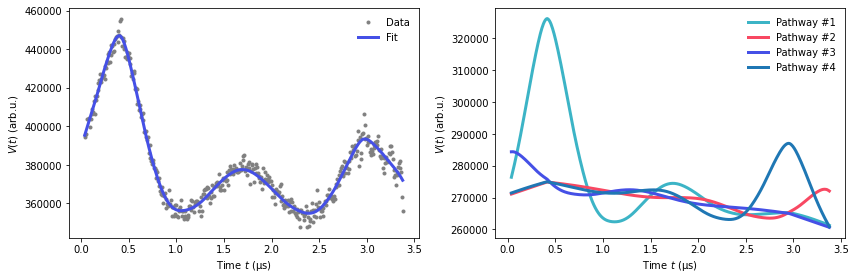

In [143]:
plot_pathway_decomposition(results)

The last step is to extract the fitted distribution and its 95%-confidence intervals as we did with the previous 4-pulse DEER data.

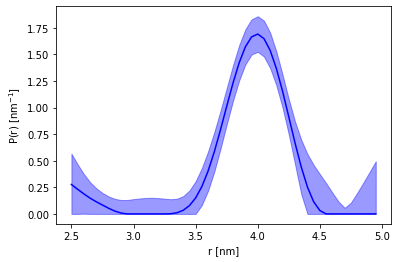

In [144]:
# Get the fitted distance distribution
Pfit = results.P
# Get the uncertainty quantification of the distance distribution
Puq = results.PUncert
# Get its 95% confidence intervals
Pci95 = Puq.ci(95)

# Get the lower/upper boundaries of the confidence intervals
Pci95_lower = Pci95[:,0]
Pci95_upper = Pci95[:,1]

# Plot the fitted distance distribution
plt.plot(r,Pfit,'b')
# Plot the confidence bands as a filled area
plt.fill_between(r,Pci95_lower,Pci95_upper,color='b',alpha=0.4)
plt.xlabel('r [nm]')
plt.ylabel('P(r) [nm$^{-1}$]')
plt.show()

------------------
## Exercise 2.5 

Go to ``Exercise 2.5`` on the exercise file: ``02b-deerlab-fitting-handson.ipynb``

-------------------

## Compactness regularization for robust analyses



For noisy experimental traces of insufficient length, the separation of the background is not unique. This leads ambiguity between the background model parameters and the long-distance region of the intra-molecular distance distribution, resulting in often so-called "long-distance artifacts".

<img src="https://raw.githubusercontent.com/JeschkeLab/DeerLabWorkshop2022/2746d801bdf97b7afd75d4f666d8fd414af490d8/images/example_identiability.svg" style="width:700px">

In its latest versions, DeerLab introduced a regularization approach that solves this problem by including an additional penalty term in the objective function that is proportional to the variance of the distance distribution and thereby penalizes non-compact distributions. 

This has been shown to provide a reliable and robust approach to analyzing dipolar signals, and makes the definition of the ``r`` vector arbitrary. Its use is **highly recommended** to ensure a unique and robust analysis of the data. The only drawback, is the additional computation cost associated to an additional regularization penalty.

- See *Compactness regularization in the analysis of dipolar EPR spectroscopy data*, JMR, 339, 2022, 107218 (freely [available online](https://doi.org/10.1016/j.jmr.2022.107218)) for details. 

In this demonstration we will quickly show the symptoms of such a problem and how to treat it with DeerLab. We will re-use the data we first analyzed in at the beginning of this tutorial and artifically truncate it to 3μs. 

First, let's load, pre-process, and construct the model of the data.

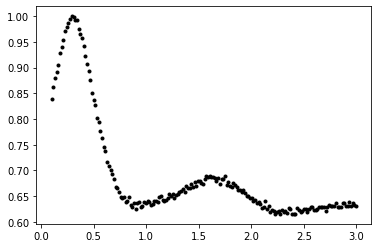

In [145]:
# File location
path = '../../data/'
file = 'example_4pdeer_1.DTA'

# Experimental parameters
tau1 = 0.3      # First inter-pulse delay, μs
tau2 = 4.0      # Second inter-pulse delay, μs
t0 = 0.1        # Acquisition delay, μs

# Load the experimental data
t,Vexp = dl.deerload(path + file)

# Pre-processing
Vexp = dl.correctphase(Vexp) # Phase correction
Vexp = Vexp/np.max(Vexp)     # Rescaling (aesthetic)
t = t - min(t) + t0          # Account for delay

# Artifically truncate the signal
Vexp = Vexp[t<=3]
t = t[t<=3]

# Distance vector
r = np.arange(1.5,7,0.05) # nm

# Construct the model
Vmodel = dl.dipolarmodel(t,r, experiment=dl.ex_4pdeer(tau1,tau2, pathways=[1]))

plt.plot(t,Vexp,'k.')
plt.show()

The following is just a function definition to quickly plot a nice figure with the dipolar signal and distance distribution fits. The code was directly copied from [this example](https://jeschkelab.github.io/DeerLab/auto_examples/basic/ex_compactness_with_without.html#sphx-glr-auto-examples-basic-ex-compactness-with-without-py) in the DeerLab documentation.

In [146]:
def plot_all(results):
    # Extract fitted dipolar signal
    Vfit = results.model
    Vci = results.modelUncert.ci(95)

    # Extract fitted distance distribution
    Pfit = results.P
    Pci95 = results.PUncert.ci(95)
    Pci50 = results.PUncert.ci(50)

    # Extract the unmodulated contribution
    Bfcn = lambda mod,conc: results.P_scale*(1-mod)*dl.bg_hom3d(t,conc,mod)
    Bfit = Bfcn(results.mod,results.conc)
    Bci = results.propagate(Bfcn).ci(95)

    plt.figure(figsize=[10,7])
    plt.subplot(2,2,1)
    # Plot experimental and fitted data
    plt.plot(t,Vexp,'.',color='grey',label='Data')
    plt.plot(t,Vfit,linewidth=3,color='b',label='Fit')
    plt.fill_between(t,Vci[:,0],Vci[:,1],color='b',alpha=0.3)
    plt.plot(t,Bfit,'--',linewidth=3,color='b',label='Unmodulated contribution')
    plt.fill_between(t,Bci[:,0],Bci[:,1],color='b',alpha=0.3)
    plt.legend(frameon=False,loc='best')
    plt.xlabel('Time $t$ (μs)')
    plt.ylabel('$V(t)$ (arb.u.)')
    # Plot the distance distribution
    plt.subplot(2,2,2)
    plt.plot(r,Pfit,color='b',linewidth=3,label='Fit')
    plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color='b',label='95%-Conf. Inter.',linewidth=0)
    plt.fill_between(r,Pci50[:,0],Pci50[:,1],alpha=0.5,color='b',label='50%-Conf. Inter.',linewidth=0)
    plt.legend(frameon=False,loc='best')
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.ylim([0,2.5])
    plt.xlabel('Distance $r$ (nm)')
    plt.ylabel('$P(r)$ (nm$^{-1}$)')
    plt.tight_layout()
    plt.show()

Let's first run the analysis as we have done in the previous examples and exercises.

[11-8-2022 5:44:12] Preparing the SNLLS analysis...
[11-8-2022 5:44:12] Preparations completed.
[11-8-2022 5:44:12] Non-linear least-squares routine in progress...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.5860e-01                                    4.86e+00    
       1              2         1.6512e-01      7.93e-01       1.03e+02       2.77e+00    
       2              3         1.5629e-02      1.49e-01       1.28e+02       7.03e-02    
       3              4         6.9677e-03      8.66e-03       5.17e+01       5.09e-02    
       4              5         1.6832e-03      5.28e-03       6.27e+01       2.83e-02    
       5              6         1.3610e-03      3.22e-04       1.59e+01       1.78e-02    
       6              7         1.3410e-03      2.00e-05       1.40e+00       3.21e-03    
       7              8         1.3183e-03      2.27e-05       2.89e+01       8.88e-03    
       8         

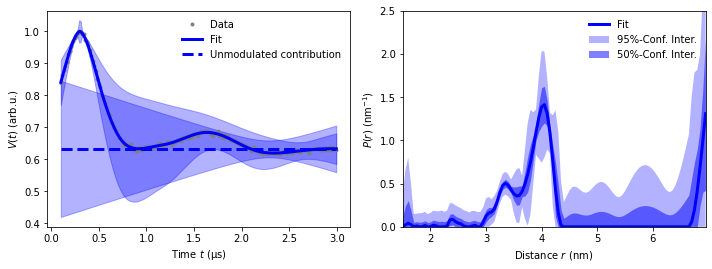

In [147]:
# Fit the model to the data without compactness criterion
results = dl.fit(Vmodel,Vexp,verbose=2, regparam=0.02, ftol=1e-3)
# Usually leave the regparam and ftol options to their defaults (here needed due to low resources)

print(results)
plot_all(results)

[11-8-2022 5:44:16] Preparing the SNLLS analysis...
[11-8-2022 5:44:16] Preparations completed.
[11-8-2022 5:44:16] Non-linear least-squares routine in progress...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.5865e-01                                    4.86e+00    
       1              2         1.6520e-01      7.93e-01       1.03e+02       2.77e+00    
       2              3         1.5464e-02      1.50e-01       1.27e+02       7.29e-02    
       3              4         6.8557e-03      8.61e-03       5.16e+01       5.10e-02    
       4              5         1.6894e-03      5.17e-03       6.19e+01       2.82e-02    
       5              6         1.3766e-03      3.13e-04       1.57e+01       1.82e-02    
       6              7         1.3568e-03      1.98e-05       1.38e+00       4.25e-03    
       7              8         1.3555e-03      1.33e-06       3.94e-01       9.79e-04    
`ftol` terminatio

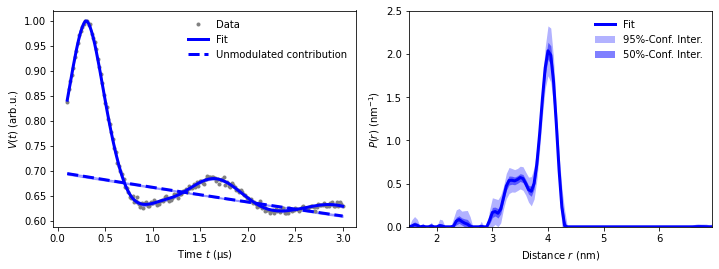

In [148]:
# Define the compactness penalty
compactness = dl.dipolarpenalty(Pmodel=None,r=r,type='compactness')
compactness.weight.freeze(0.009) # Remove this line for automatic optimization of the penalty weight

# Fit the model to the data with compactness criterion
results = dl.fit(Vmodel,Vexp, penalties=compactness,verbose=2, regparam=0.02, ftol=1e-3)
# Usually leave the regparam and ftol options to their defaults (here needed due to low resources)

print(results)
plot_all(results)

-----------------------